<h1 style="text-align: center;">Offline Post-Processing with <em>femtoscope<em></h1>

This notebook shows how to post-process FEM computation results **offline**.

*prerequisites* :
- `mesh_generation_basics` notebook
- `linear_problems` notebook

**If you have questions/comments or want to report a bug, please send me an email at <a href="mailto:hugo.levy@onera.fr">hugo.levy@onera.fr</a>**

In [1]:
# Add femtoscope to the path
%reset
%matplotlib inline
import sys
sys.path.append("../") # go to parent dir

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Motivations
Right after solving a given PDE problem with *femtoscope*, the solution (together with other relevant fields) can be readily saved to a VTK file. This archive can be later consulted (e.g. using meshio in Python, or the Paraview software). The issue with this solution is that we loose interpolation using basis functions (especially when using Lagrange finite elements of order 2, 3 or more). In particular, it would be great if we could use the `evaluate_at()` method from Sfepy.

## Implementation
This feature has been implemented in femtoscope. The idea to make this work is to save some `solver` metadatas alongside the VTK files. These metadatas contain information to reconstruct (partially) the `WeakForm` instances that were used in the first place, allowing for the use of the correct FE basis functions.

## Example

### Step 1: Saving Results

Let us show how this is done in practice.

In [2]:
from femtoscope.physics.physical_problems import Poisson
from femtoscope.inout.meshfactory import MeshingTools
from numpy import pi

alpha = 4*pi
Rc = 5.0
dim = 2
sa = 1.2
sc = 0.8
coorsys = 'cylindrical'
meshint_name = 'mesh_test_sphere_int.vtk'
meshext_name = 'mesh_test_sphere_ext.vtk'

def get_pre_meshes():
    return mesh2dcyl_int(), mesh2dcyl_ext()

def mesh2dcyl_int():
    mt = MeshingTools(2)
    s1 = mt.create_ellipse(rx=sa, ry=sc)
    mt.create_subdomain(cell_size_min=0.05, cell_size_max=0.2,
                        dist_min=0.0, dist_max=4.0)
    s2 = mt.create_disk_from_pts(Rc, N=200)
    mt.subtract_shapes(s2, s1, removeObject=True, removeTool=False)
    mt.create_subdomain(cell_size_min=0.2, cell_size_max=0.2)
    return mt.generate_mesh(meshint_name, cylindrical_symmetry=True,
                            show_mesh=False, ignored_tags=[200])

def mesh2dcyl_ext():
    mt = MeshingTools(2)
    mt.create_disk_from_pts(Rc, N=200)
    mt.create_subdomain(cell_size_min=0.2, cell_size_max=0.2)
    origin_rf = [0.07, 0.2, 0.1, 3.0]
    return mt.generate_mesh(
        meshext_name, cylindrical_symmetry=True, show_mesh=False,
        embed_origin=True, origin_rf=origin_rf)

poisson = Poisson({'alpha': alpha}, dim, Rc=Rc, coorsys=coorsys)
pre_mesh_int, pre_mesh_ext = get_pre_meshes()
partial_args_dict_int = {
    'dim': dim,
    'name': 'wf_int',
    'pre_mesh': pre_mesh_int,
    'fem_order': 2,
}
partial_args_dict_ext = {
    'dim': dim,
    'name': 'wf_ext',
    'pre_mesh': pre_mesh_ext,
    'fem_order': 2,
}

partial_args_dict_ext['pre_ebc_dict'] = {('vertex', 0): 0.0}
region_key_int = ('facet', 201)
region_key_ext = ('facet', 200)

poisson.set_wf_int(partial_args_dict_int, {('subomega', 300): 1.0})
poisson.set_wf_ext(partial_args_dict_ext, density=None)
poisson.set_default_solver(region_key_int=region_key_int,
                           region_key_ext=region_key_ext)

solver = poisson.default_solver
solver.solve()

In order to save metadatas in addition to the VTK file, we use the `solver.save_results` method.

In [3]:
solver.save_results('test_offline_postprocessing')

This created a folder named 'test_offline_postprocessing' in `femtoscope\\data\\result` containing:
- .vtk files --> containing the solution vectors
- .pkl files --> files created using the `pickle` module and containing solver metadatas for reconstructing the weak forms

### Step 2) Post-process offline & Enjoy
To simulate an offline configuration, we delete all FEM-related variables 

In [4]:
%reset -f

In [5]:
from femtoscope.inout.postprocess import ResultsPostProcessor
result_pp = ResultsPostProcessor.from_files('test_offline_postprocessing')

From here, one can use the various attributes & `evaluate_at` that come with `result_pp`:

[-5.01075384 -4.29675551 -5.01075496 ... -0.95882869 -0.95882866
 -0.97816027]


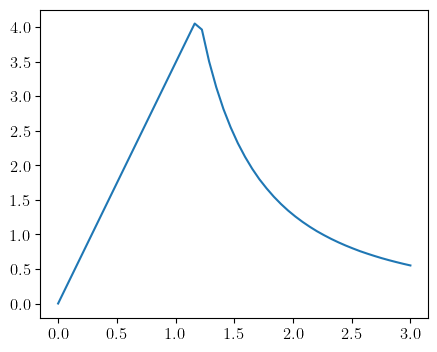

In [6]:
import numpy as np
from matplotlib import pyplot as plt

sol_int = result_pp.sol_int
print(sol_int)

X = np.linspace(0, 3, 50)
Z = np.zeros_like(X)
coors = np.concatenate((X[:, np.newaxis], Z[:, np.newaxis]), axis=1)
grad = result_pp.evaluate_at(coors, key='sol_int', mode='grad')
plt.figure(figsize=(5, 4))
plt.plot(X, grad[:, 0])
plt.show()

In [7]:
# Finally, remove the directory
from pathlib import Path
import shutil
from femtoscope import RESULT_DIR
dir_path = Path(RESULT_DIR / 'test_offline_postprocessing')
shutil.rmtree(dir_path)